# Best City to Study in

### Coursera IBM Applied Data Science - Capstone Course

by Joseph M Camilleri

Import necessary modules

In [6]:
import pandas as pd # manipulate data with dataframes

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import numpy as np

# import k-means from clustering stage
from sklearn.cluster import KMeans

# import matplotlib to draw graphs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.spatial import ConvexHull
import warnings; warnings.simplefilter('ignore')

from IPython.display import display, Markdown #to generate markdown programmatically

# constants for Foursquare API
radius = 1000 #radius to search for
LIMIT = 100 # maximum records to return

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

# Data Preparation

Create the main datafame to hold the Cities to be considered by the student

In [7]:
cities = {'City': ['London','Tokyo','Melbourne','Munich','Berlin','Montreal','New York','Boston','Edinburgh','Dublin','Paris'],
        'Country': ['United Kingdom','Japan','Australia','Germany','Germany','Canada','United States','United States','United Kingdom','Ireland','France']}
Cities = pd.DataFrame(cities, columns = ['City','Country'])
Cities

,City,Country
0,London,United Kingdom
1,Tokyo,Japan
2,Melbourne,Australia
3,Munich,Germany
4,Berlin,Germany
5,Montreal,Canada
6,New York,United States
7,Boston,United States
8,Edinburgh,United Kingdom
9,Dublin,Ireland


Define the types of venue of interest to the student

In [8]:
interest_df = {'interest': ['Theater','Basketball','Track','University','Italian','Dance']}
interest_df = pd.DataFrame(interest_df, columns = ['interest'])
interest_df

,interest
0,Theater
1,Basketball
2,Track
3,University
4,Italian
5,Dance


Use Pandas read_html to extract data into 2 list of tables (dataframes) from the HTML pages for crime and cost of living ranking of cities respectivley

In [9]:
safety_url = 'https://www.numbeo.com/crime/rankings.jsp'
safety_list = pd.read_html(safety_url)
cost_url = 'https://www.numbeo.com/cost-of-living/rankings.jsp'
cost_list = pd.read_html(cost_url)

Check how many tables have been read

In [10]:
print('Safety List contains ',len(safety_list),' tables')
print('Cost of Living List contains ',len(cost_list),' tables')

Safety List contains  3  tables
Cost of Living List contains  3  tables


Check the contents of each table in the list from the Safety Index Website

In [15]:
for index in range(3):
    print('\n\nSafety Table Number: ',index) #skip 2 lines for better formatting and readablility
    print(safety_list[index])



Safety Table Number:  0
    0                                                  1
0 NaN  whenDocReady(function() {  jQuery('#city_selec...


Safety Table Number:  1
    0      1
0 NaN  Tweet


Safety Table Number:  2
     Rank                                City  Crime Index  Safety Index
0     NaN                  Caracas, Venezuela        84.57         15.43
1     NaN              Pretoria, South Africa        81.89         18.11
2     NaN            San Pedro Sula, Honduras        81.35         18.65
3     NaN      Port Moresby, Papua New Guinea        81.05         18.95
4     NaN      Pietermaritzburg, South Africa        80.93         19.07
5     NaN                Durban, South Africa        80.80         19.20
6     NaN          Johannesburg, South Africa        80.31         19.69
7     NaN                   Fortaleza, Brazil        78.51         21.49
8     NaN              Rio de Janeiro, Brazil        77.42         22.58
9     NaN                  Kabul, Afghanistan       

Check the contents of each table in the list from the Cost of Living Index Website

In [14]:
for index in range(3):
    print('\n\nCost of Living Table Number: ',index) #skip 2 lines for better formatting and readablility
    print(cost_list[index])



Cost of Living Table Number:  0
    0                                                  1
0 NaN  whenDocReady(function() {  jQuery('#city_selec...


Cost of Living Table Number:  1
    0      1
0 NaN  Tweet


Cost of Living Table Number:  2
     Rank                              City  Cost of Living Index  Rent Index  \
0     NaN               Zurich, Switzerland                131.49       64.37   
1     NaN               Lugano, Switzerland                130.75       40.20   
2     NaN                Basel, Switzerland                130.65       46.61   
3     NaN               Geneva, Switzerland                126.08       66.56   
4     NaN             Lausanne, Switzerland                125.03       51.99   
5     NaN                 Bern, Switzerland                116.53       41.60   
6     NaN       New York, NY, United States                100.00      100.00   
7     NaN                 Trondheim, Norway                 98.23       34.32   
8     NaN                 Sta

Create two dataframes for each table (table number 2) for Safety and Cost of Living

In [17]:
safety_df=safety_list[2]
cost_df=cost_list[2]

Let's have a look at the Safety dataframe

In [18]:
print('Safety data frame')
safety_df.head()

Safety data frame


,Rank,City,Crime Index,Safety Index
0,NaN,"Caracas, Venezuela",84.57,15.43
1,NaN,"Pretoria, South Africa",81.89,18.11
2,NaN,"San Pedro Sula, Honduras",81.35,18.65
3,NaN,"Port Moresby, Papua New Guinea",81.05,18.95
4,NaN,"Pietermaritzburg, South Africa",80.93,19.07


Prepare the Safety data frame by splitting out the City and the Country and removing the extra columns

In [19]:
# split city column into city name, state initials and country name
safety_df[['City1','City2','City3']] = safety_df.City.str.split(',',expand=True) 
# the state initials are in the middle and will be in City2
# where there are no state initials the country name will be in City 2
# this in such cases we copy City2 into City3 to ensure the country is in City 3
safety_df.City3 = safety_df.City2.where(safety_df['City3'].isnull(),safety_df['City3'])
# we eliminate the extra comma from the country name
safety_df['City3'] = safety_df['City3'].str[1:]
# drop the uncessary columns
cols = [0,1,2,5]
safety_df=safety_df.drop(safety_df.columns[cols],axis=1,inplace=False)
# rename columns City 1 and City 3 to City and Country respectivley
safety_df.columns = ['Safety Index', 'City', 'Country']
#check out the resulting data frame showing rows of US cities which included the state initials
safety_df.iloc[ 170:180 , : ]

,Safety Index,City,Country
170,54.14,Newcastle,Australia
171,54.27,Lodz,Poland
172,54.29,New York,United States
173,54.46,Katowice,Poland
174,54.50,Buffalo,United States
175,54.63,Kristiansand,Norway
176,54.70,Toulouse,France
177,54.82,Chisinau,Moldova
178,54.83,Tunis,Tunisia
179,54.94,San Jose,United States


Let's have a look at the Cost  dataframe

In [20]:
print('Cost data frame')
cost_df.head()

Cost data frame


,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,NaN,"Zurich, Switzerland",131.49,64.37,98.80,131.23,120.39,121.12
1,NaN,"Lugano, Switzerland",130.75,40.20,86.66,134.80,115.19,101.15
2,NaN,"Basel, Switzerland",130.65,46.61,89.72,126.05,131.92,109.90
3,NaN,"Geneva, Switzerland",126.08,66.56,97.10,123.84,119.47,108.09
4,NaN,"Lausanne, Switzerland",125.03,51.99,89.46,125.56,118.13,110.86


Prepare the Cost data frame by splitting out the City and the Country and removing the extra columns

In [21]:
# split city column into city name, state initials and country name
cost_df[['City1','City2','City3']] = cost_df.City.str.split(',',expand=True) 
# the state initials are in the middle and will be in City2
# where there are no state initials the country name will be in City 2
# this in such cases we copy City2 into City3 to ensure the country is in City 3
cost_df.City3 = cost_df.City2.where(cost_df['City3'].isnull(),cost_df['City3'])
# we eliminate the extra comma from the country name
cost_df['City3'] = cost_df['City3'].str[1:]
# drop the unwanted columns
cols = [0,1,3,4,5,6,7,9]
cost_df=cost_df.drop(cost_df.columns[cols],axis=1,inplace=False)
# rename columns City 1 and City 3 to City and Country respectivley
cost_df.columns = ['Cost of Living Index', 'City', 'Country']
#check out the resulting data frame showing rows of US cities which included the state initials
cost_df.iloc[ 100:110 , : ]

,Cost of Living Index,City,Country
100,73.69,Brussels,Belgium
101,73.66,Antwerp,Belgium
102,73.21,Montpellier,France
103,73.12,Gothenburg,Sweden
104,73.12,Spokane,United States
105,72.98,Limerick,Ireland
106,72.82,Rome,Italy
107,72.82,Columbus,United States
108,72.81,Albany,United States
109,72.69,Sliema,Malta


Merge the 2 data frames, containg safety and cost of living data, into the cities dataframe by matching both the city and country

In [22]:
Cities = pd.merge(Cities, safety_df,  how='left', left_on=['City','Country'], right_on = ['City','Country'])
Cities = pd.merge(Cities, cost_df,  how='left', left_on=['City','Country'], right_on = ['City','Country'])
Cities

,City,Country,Safety Index,Cost of Living Index
0,London,United Kingdom,47.66,78.83
1,Tokyo,Japan,76.60,89.69
2,Melbourne,Australia,55.53,73.76
3,Munich,Germany,82.71,75.56
4,Berlin,Germany,58.92,67.02
5,Montreal,Canada,70.74,64.10
6,New York,United States,54.29,100.00
7,Boston,United States,64.48,88.61
8,Edinburgh,United Kingdom,68.70,68.54
9,Dublin,Ireland,50.42,81.39


# Compare Cities on safety and cost of living 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

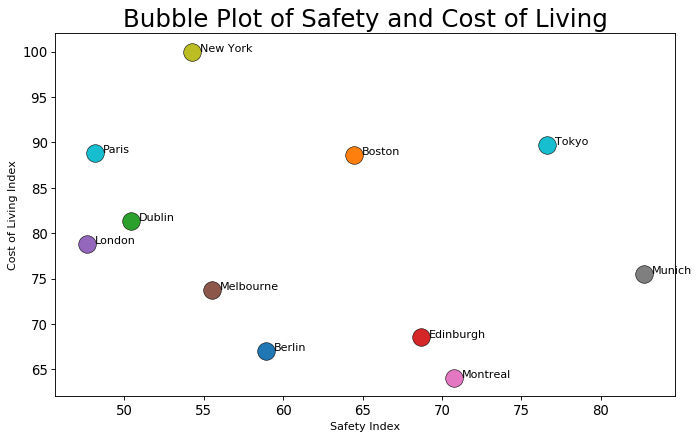

In [28]:
# As many colors as there are unique cities
categories = np.unique(Cities['City'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Draw Scatterplot with unique color for each category
fig = plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')    

for i, category in enumerate(categories):
    plt.scatter('Safety Index', 'Cost of Living Index', data=Cities.loc[Cities.City==category, :], s=250, c=colors[i], label=str(category), edgecolors='black', linewidths=.5)
    x = Cities['Safety Index'][(Cities['City'] == category)] + 0.5 # the plus 0.5 avoid the overlap of the name with the bubble
    y = Cities['Cost of Living Index'][(Cities['City'] == category)]
    plt.annotate(category, xy=(x, y)) # write the city name at the correct coordinates

#Decorations
min_x = min(Cities['Safety Index']) - 2
max_x = max(Cities['Safety Index']) + 2
min_y = min(Cities['Cost of Living Index']) - 2
max_y = max(Cities['Cost of Living Index']) + 2
plt.gca().set(xlim=(min_x, max_x), ylim=(min_y, max_y),
              xlabel='Safety Index', ylabel='Cost of Living Index')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Bubble Plot of Safety and Cost of Living", fontsize=22)
plt.legend(fontsize=12)    
plt.legend().remove() # as we have the city names next to the bubbles we can remove the legend
plt.show()    

Let's get the geographical cordinates of each City

In [29]:
# initialise values
geolocator = Nominatim(user_agent="city_explorer")
Cities["Latitude"] = 0.0
Cities["Longitude"] = 0.0

# iterate through the cities
for index, row in Cities.iterrows():
    address = row['City']+', '+row['Country']
    location = geolocator.geocode(address) 
    Cities.at[index,'Latitude'] = location.latitude
    Cities.at[index,'Longitude'] = location.longitude

Cities

,City,Country,Safety Index,Cost of Living Index,Latitude,Longitude
0,London,United Kingdom,47.66,78.83,51.507322,-0.127647
1,Tokyo,Japan,76.60,89.69,35.682839,139.759455
2,Melbourne,Australia,55.53,73.76,-37.814218,144.963161
3,Munich,Germany,82.71,75.56,48.137108,11.575382
4,Berlin,Germany,58.92,67.02,52.517037,13.388860
5,Montreal,Canada,70.74,64.10,45.497216,-73.610364
6,New York,United States,54.29,100.00,40.712728,-74.006015
7,Boston,United States,64.48,88.61,42.360253,-71.058291
8,Edinburgh,United Kingdom,68.70,68.54,55.953346,-3.188375
9,Dublin,Ireland,50.42,81.39,53.349764,-6.260273


# Check out the venues of interest in each city

Add the interest as columns in the Cities dataframe

In [31]:
# loop through interests of student
for ind in interest_df.index: 
    Cities[interest_df['interest'][ind]] = 0 # add a new column for each interest
    
Cities

,City,Country,Safety Index,Cost of Living Index,Latitude,Longitude,Theater,Basketball,Track,University,Italian,Dance
0,London,United Kingdom,47.66,78.83,51.507322,-0.127647,0,0,0,0,0,0
1,Tokyo,Japan,76.60,89.69,35.682839,139.759455,0,0,0,0,0,0
2,Melbourne,Australia,55.53,73.76,-37.814218,144.963161,0,0,0,0,0,0
3,Munich,Germany,82.71,75.56,48.137108,11.575382,0,0,0,0,0,0
4,Berlin,Germany,58.92,67.02,52.517037,13.388860,0,0,0,0,0,0
5,Montreal,Canada,70.74,64.10,45.497216,-73.610364,0,0,0,0,0,0
6,New York,United States,54.29,100.00,40.712728,-74.006015,0,0,0,0,0,0
7,Boston,United States,64.48,88.61,42.360253,-71.058291,0,0,0,0,0,0
8,Edinburgh,United Kingdom,68.70,68.54,55.953346,-3.188375,0,0,0,0,0,0
9,Dublin,Ireland,50.42,81.39,53.349764,-6.260273,0,0,0,0,0,0


Define Foursquare Credentials and Version

In [32]:
CLIENT_ID = 'HZU4IZ12TXWTZIKPO1KZNFJUX35ESNIYCN3KGZWGA1QVETDQ' # my Foursquare ID
CLIENT_SECRET = 'AZT25W3KWSFHHQKICKPY2GKT0OVWKGNTVAWOE0LZ54ZCCC5S' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [33]:
for ind_1 in Cities.index: # outter loop: iterate through cities
    for ind_2 in interest_df.index: # inner loop: interate through interests
        lat = Cities['Latitude'][ind_1]
        long = Cities['Longitude'][ind_1]
        search_query = interest_df['interest'][ind_2]
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, long, VERSION, search_query, radius, LIMIT)
        results = requests.get(url).json()
        temp_venues = results['response']['venues']
        Cities.iloc[ind_1, Cities.columns.get_loc(interest_df['interest'][ind_2])] = len(temp_venues) # store number of venues in the correct cell

Cities

,City,Country,Safety Index,Cost of Living Index,Latitude,Longitude,Theater,Basketball,Track,University,Italian,Dance
0,London,United Kingdom,47.66,78.83,51.507322,-0.127647,22,1,3,10,31,8
1,Tokyo,Japan,76.60,89.69,35.682839,139.759455,5,0,1,1,9,1
2,Melbourne,Australia,55.53,73.76,-37.814218,144.963161,2,5,2,50,19,15
3,Munich,Germany,82.71,75.56,48.137108,11.575382,23,1,4,1,12,3
4,Berlin,Germany,58.92,67.02,52.517037,13.388860,18,3,1,3,5,0
5,Montreal,Canada,70.74,64.10,45.497216,-73.610364,0,0,0,1,0,1
6,New York,United States,54.29,100.00,40.712728,-74.006015,26,10,14,50,22,35
7,Boston,United States,64.48,88.61,42.360253,-71.058291,27,2,31,50,26,5
8,Edinburgh,United Kingdom,68.70,68.54,55.953346,-3.188375,3,0,1,42,8,4
9,Dublin,Ireland,50.42,81.39,53.349764,-6.260273,6,0,2,7,13,8


In order to better visualise the data of interest above in relative term in each city, the interest numbers will be normalised

In [34]:
for ind_2 in interest_df.index:
    Col_head = interest_df['interest'][ind_2]
    Cities[Col_head] = Cities[Col_head]/Cities[Col_head].max()

Cities

,City,Country,Safety Index,Cost of Living Index,Latitude,Longitude,Theater,Basketball,Track,University,Italian,Dance
0,London,United Kingdom,47.66,78.83,51.507322,-0.127647,0.814815,0.1,0.096774,0.20,1.000000,0.228571
1,Tokyo,Japan,76.60,89.69,35.682839,139.759455,0.185185,0.0,0.032258,0.02,0.290323,0.028571
2,Melbourne,Australia,55.53,73.76,-37.814218,144.963161,0.074074,0.5,0.064516,1.00,0.612903,0.428571
3,Munich,Germany,82.71,75.56,48.137108,11.575382,0.851852,0.1,0.129032,0.02,0.387097,0.085714
4,Berlin,Germany,58.92,67.02,52.517037,13.388860,0.666667,0.3,0.032258,0.06,0.161290,0.000000
5,Montreal,Canada,70.74,64.10,45.497216,-73.610364,0.000000,0.0,0.000000,0.02,0.000000,0.028571
6,New York,United States,54.29,100.00,40.712728,-74.006015,0.962963,1.0,0.451613,1.00,0.709677,1.000000
7,Boston,United States,64.48,88.61,42.360253,-71.058291,1.000000,0.2,1.000000,1.00,0.838710,0.142857
8,Edinburgh,United Kingdom,68.70,68.54,55.953346,-3.188375,0.111111,0.0,0.032258,0.84,0.258065,0.114286
9,Dublin,Ireland,50.42,81.39,53.349764,-6.260273,0.222222,0.0,0.064516,0.14,0.419355,0.228571


Let's prepare a tempoary table to plot the data into a bar chart to visualise it

In [37]:
graph_df = Cities.copy()
graph_df.drop(graph_df.columns[1:6], axis=1, inplace=True)
graph_df.set_index('City', inplace=True)
graph_df

,Theater,Basketball,Track,University,Italian,Dance
City,,,,,,
London,0.814815,0.1,0.096774,0.20,1.000000,0.228571
Tokyo,0.185185,0.0,0.032258,0.02,0.290323,0.028571
Melbourne,0.074074,0.5,0.064516,1.00,0.612903,0.428571
Munich,0.851852,0.1,0.129032,0.02,0.387097,0.085714
Berlin,0.666667,0.3,0.032258,0.06,0.161290,0.000000
Montreal,0.000000,0.0,0.000000,0.02,0.000000,0.028571
New York,0.962963,1.0,0.451613,1.00,0.709677,1.000000
Boston,1.000000,0.2,1.000000,1.00,0.838710,0.142857
Edinburgh,0.111111,0.0,0.032258,0.84,0.258065,0.114286


Let's compare the cities relative to the interests of the student using a bar chart

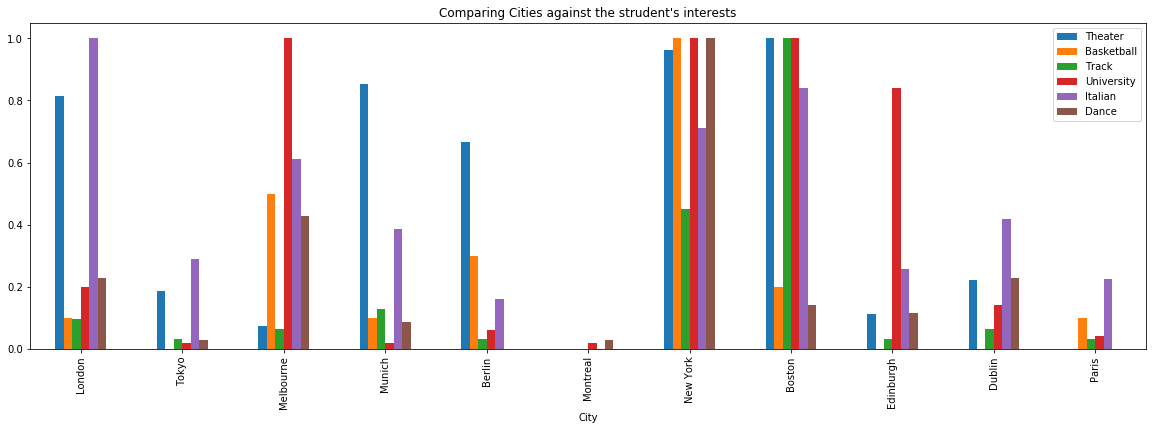

In [38]:
graph_df.plot(kind='bar', figsize=(20, 6)) # plot a bar chart

plt.xlabel('City') # add to x-label to the plot
plt.title('Comparing Cities against the strudent\'s interests') # add title to the plot

plt.show()

# Explore each city and chck out the most common venues

First we need to define a couple of functions

In [39]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [40]:
# This function below is to exract venues in all the cities
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('   '+name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get the nearby vanues for each city centre

In [41]:
# Run the above function on each city and create a new dataframe called venues
print('Explore API call for ...')
venues = getNearbyVenues(names=Cities['City'],
                                   latitudes=Cities['Latitude'],
                                   longitudes=Cities['Longitude']
                                  )
print('-- Done --')

Explore API call for ...
   London
   Tokyo
   Melbourne
   Munich
   Berlin
   Montreal
   New York
   Boston
   Edinburgh
   Dublin
   Paris
-- Done --


How much data has been retrieved?

In [46]:
print('The size of the venues dataframe is: ', end = '')
print(venues.shape)
print('\nAnd this is what the venues dataframe looks like:')
venues.head()

The size of the venues dataframe is: (945, 7)

And this is what the venues dataframe looks like:


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,London,51.507322,-0.127647,National Gallery,51.508876,-0.128478,Art Museum
1,London,51.507322,-0.127647,Trafalgar Square,51.507987,-0.128048,Plaza
2,London,51.507322,-0.127647,East Trafalgar Square Fountain,51.508088,-0.127700,Fountain
3,London,51.507322,-0.127647,ESPA Life at Corinthia,51.506402,-0.125114,Spa
4,London,51.507322,-0.127647,Trafalgar Square Lions,51.507641,-0.127888,Outdoor Sculpture


Let's check how many venues were returned for each city by plotting a horizontal graph

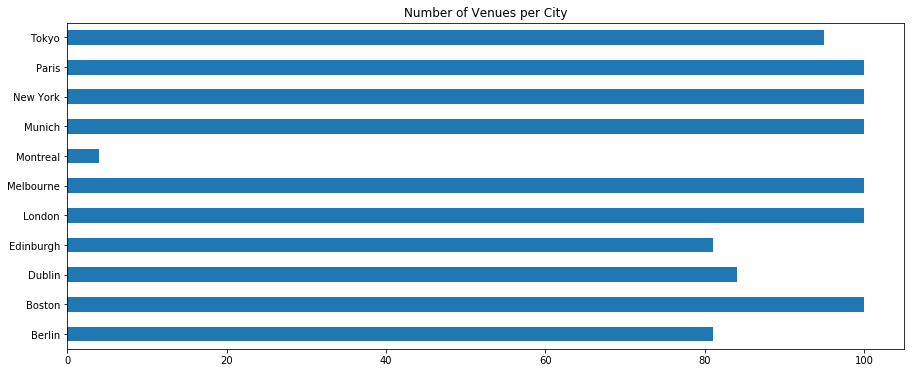

In [47]:
# create a tempoary table with the necessary data
graph_df = venues.groupby('City').count().copy()
graph_df.drop(graph_df.columns[1:6], axis=1, inplace=True)

graph_df.plot(kind='barh', figsize=(15, 6))

plt.ylabel('')
plt.legend().remove() # no legend is necesary
plt.title('Number of Venues per City') # add title to the plot

plt.show()

Let's find out how many unique categories can be curated from all the returned venues

In [56]:
print('There are {} uniques categories listed below:\n'.format(len(venues['Venue Category'].unique())))
print(venues['Venue Category'].unique())

There are 211 uniques categories listed below:

['Art Museum' 'Plaza' 'Fountain' 'Spa' 'Outdoor Sculpture' 'Hotel'
 'Church' 'Monument / Landmark' 'North Indian Restaurant' 'Tea Room'
 'Spanish Restaurant' 'Art Gallery' 'Bookstore' 'Restaurant' 'Wine Bar'
 'Italian Restaurant' 'Thai Restaurant' 'Pub' 'Theater' 'Coffee Shop'
 'Garden' 'Burger Joint' 'Café' 'Ice Cream Shop' 'Boutique'
 'Indie Movie Theater' 'Japanese Restaurant' 'Steakhouse' 'Park'
 'Pharmacy' 'Cocktail Bar' 'Liquor Store' 'Greek Restaurant'
 'Toy / Game Store' 'Sandwich Place' 'Gay Bar' 'Bakery'
 'Pakistani Restaurant' 'Bar' 'Lounge' 'Tour Provider' 'French Restaurant'
 'Comedy Club' 'Chinese Restaurant' 'Ramen Restaurant' 'Sushi Restaurant'
 'Candy Store' 'Lebanese Restaurant' 'Noodle House' 'Irish Pub'
 'Seafood Restaurant' 'English Restaurant' 'Multiplex' 'Event Space'
 'Modern European Restaurant' 'American Restaurant' 'Road' 'Historic Site'
 'Dessert Shop' 'Brazilian Restaurant' 'Paper / Office Supplies Store'
 'Me

Prepare data to analyse each city's venues using One Hot Encoding

In [57]:
# set-up one hot encoding dataframe
cities_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
cities_onehot['City'] = venues['City'] 

# move city column to the first column
Ct = cities_onehot['City']
cities_onehot.drop(labels=['City'], axis=1,inplace = True)
cities_onehot.insert(0, 'City', Ct)

cities_onehot.head()

,City,Alsatian Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auvergne Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant
0,London,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


What is the size of the new dataframe

In [51]:
cities_onehot.shape

(945, 212)

Group rows by city and by taking the mean of the frequency of occurrence of each category

In [52]:
cities_grouped = cities_onehot.groupby('City').mean().reset_index()
cities_grouped

,City,Alsatian Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auvergne Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant
0,Berlin,0.00,0.000000,0.00,0.000000,0.012346,0.00,0.000000,0.000000,0.00,...,0.000000,0.024691,0.000000,0.000000,0.037037,0.00,0.000000,0.00,0.00,0.000000
1,Boston,0.00,0.010000,0.00,0.000000,0.000000,0.00,0.000000,0.010000,0.00,...,0.000000,0.010000,0.000000,0.000000,0.000000,0.01,0.000000,0.00,0.02,0.000000
2,Dublin,0.00,0.011905,0.00,0.000000,0.011905,0.00,0.000000,0.000000,0.00,...,0.011905,0.000000,0.011905,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000
3,Edinburgh,0.00,0.012346,0.00,0.012346,0.024691,0.00,0.000000,0.012346,0.00,...,0.000000,0.012346,0.000000,0.037037,0.000000,0.00,0.012346,0.00,0.00,0.000000
4,London,0.00,0.000000,0.00,0.000000,0.020000,0.02,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.030000,0.00,0.000000,0.00,0.00,0.000000
5,Melbourne,0.00,0.000000,0.00,0.010000,0.010000,0.00,0.000000,0.010000,0.00,...,0.000000,0.000000,0.000000,0.010000,0.010000,0.00,0.000000,0.00,0.00,0.000000
6,Montreal,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000
7,Munich,0.00,0.000000,0.00,0.010000,0.000000,0.01,0.000000,0.000000,0.00,...,0.000000,0.010000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000
8,New York,0.00,0.020000,0.01,0.000000,0.000000,0.00,0.000000,0.010000,0.00,...,0.000000,0.010000,0.000000,0.000000,0.000000,0.02,0.000000,0.01,0.02,0.000000
9,Paris,0.01,0.000000,0.00,0.000000,0.040000,0.01,0.010000,0.000000,0.01,...,0.000000,0.000000,0.000000,0.000000,0.030000,0.00,0.000000,0.01,0.00,0.000000


The size of the new data frame having one row per city and one column per venue category

In [53]:
cities_grouped.shape

(11, 212)

Print each city along with the top 5 most common venues in order to get an idea of the most common venues in each city

In [58]:
num_top_venues = 5 # we can change this if necessary

for hood in cities_grouped['City']:
    print("----"+hood+"----")
    temp = cities_grouped[cities_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berlin----
                venue  freq
0               Hotel  0.10
1   German Restaurant  0.07
2  Italian Restaurant  0.05
3         Coffee Shop  0.05
4      Clothing Store  0.04


----Boston----
                venue  freq
0  Italian Restaurant  0.15
1         Coffee Shop  0.06
2       Historic Site  0.06
3              Bakery  0.05
4  Seafood Restaurant  0.05


----Dublin----
         venue  freq
0          Pub  0.08
1  Coffee Shop  0.08
2         Café  0.07
3        Hotel  0.06
4   Restaurant  0.05


----Edinburgh----
        venue  freq
0       Hotel  0.15
1         Bar  0.09
2  Restaurant  0.07
3         Pub  0.05
4  Whisky Bar  0.04


----London----
          venue  freq
0       Theater  0.06
1         Hotel  0.05
2         Plaza  0.04
3  Cocktail Bar  0.04
4           Pub  0.03


----Melbourne----
          venue  freq
0   Coffee Shop  0.08
1           Bar  0.08
2          Café  0.06
3  Dessert Shop  0.05
4  Cocktail Bar  0.05


----Montreal----
                             

Put the above frequency data into a dataframe. 

In [59]:
#This function will sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each city

In [60]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd'] # suffix for 1st, 2nd and 3rd

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind])) # if 1st, 2nd or 3rd
    except:
        columns.append('{}th Most Common Venue'.format(ind+1)) # if not 1st, 2nd or 3rd

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = cities_grouped['City']

for ind in np.arange(cities_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berlin,Hotel,German Restaurant,Coffee Shop,Italian Restaurant,Clothing Store,Wine Bar,Café,Department Store,Bookstore,Restaurant
1,Boston,Italian Restaurant,Coffee Shop,Historic Site,Bakery,Seafood Restaurant,Pub,Sandwich Place,Park,Hotel,Restaurant
2,Dublin,Coffee Shop,Pub,Café,Hotel,Clothing Store,Bed & Breakfast,Restaurant,Department Store,Bookstore,Discount Store
3,Edinburgh,Hotel,Bar,Restaurant,Pub,Whisky Bar,Indian Restaurant,Café,Art Gallery,Comedy Club,Bakery
4,London,Theater,Hotel,Cocktail Bar,Plaza,Wine Bar,Steakhouse,Pub,Bakery,Monument / Landmark,Ice Cream Shop
5,Melbourne,Coffee Shop,Bar,Café,Cocktail Bar,Dessert Shop,Shopping Mall,Juice Bar,Clothing Store,Sushi Restaurant,Burger Joint
6,Montreal,Residential Building (Apartment / Condo),Convenience Store,Bus Station,Business Service,Exhibit,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop
7,Munich,Café,Bavarian Restaurant,Plaza,Hotel,Clothing Store,German Restaurant,Boutique,Coffee Shop,Seafood Restaurant,Department Store
8,New York,Coffee Shop,Hotel,Café,Gym,Italian Restaurant,Cocktail Bar,Pizza Place,Clothing Store,Shopping Mall,Bubble Tea Shop
9,Paris,French Restaurant,Ice Cream Shop,Art Gallery,Plaza,Gay Bar,Pub,Wine Bar,Bar,Cocktail Bar,Cosmetics Shop


## Cluster cities to deterime which cities are similar based on their most common venues
Run k-means to cluster the cities into clusters

In [61]:
# set number of clusters to be a third of the number of cities in order to force the clustering algorythm to cluster some cities together

kclusters = int(Cities.shape[0] / 3) # number of cities divided by 3
if kclusters < 2:
    kclusters = 2 # this will ensure we have at least 2 clusters

cities_grouped_clustering = cities_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each city.

In [62]:
# add clustering labels
cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cities_merged = Cities

# merge toronto_grouped with toronto_data to add latitude/longitude for each city
cities_merged = cities_merged.join(cities_venues_sorted.set_index('City'), on='City')

cities_merged 

,City,Country,Safety Index,Cost of Living Index,Latitude,Longitude,Theater,Basketball,Track,University,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,London,United Kingdom,47.66,78.83,51.507322,-0.127647,0.814815,0.1,0.096774,0.20,...,Theater,Hotel,Cocktail Bar,Plaza,Wine Bar,Steakhouse,Pub,Bakery,Monument / Landmark,Ice Cream Shop
1,Tokyo,Japan,76.60,89.69,35.682839,139.759455,0.185185,0.0,0.032258,0.02,...,Historic Site,Italian Restaurant,Japanese Restaurant,Convenience Store,French Restaurant,Café,Park,Chinese Restaurant,Business Center,Hotel Bar
2,Melbourne,Australia,55.53,73.76,-37.814218,144.963161,0.074074,0.5,0.064516,1.00,...,Coffee Shop,Bar,Café,Cocktail Bar,Dessert Shop,Shopping Mall,Juice Bar,Clothing Store,Sushi Restaurant,Burger Joint
3,Munich,Germany,82.71,75.56,48.137108,11.575382,0.851852,0.1,0.129032,0.02,...,Café,Bavarian Restaurant,Plaza,Hotel,Clothing Store,German Restaurant,Boutique,Coffee Shop,Seafood Restaurant,Department Store
4,Berlin,Germany,58.92,67.02,52.517037,13.388860,0.666667,0.3,0.032258,0.06,...,Hotel,German Restaurant,Coffee Shop,Italian Restaurant,Clothing Store,Wine Bar,Café,Department Store,Bookstore,Restaurant
5,Montreal,Canada,70.74,64.10,45.497216,-73.610364,0.000000,0.0,0.000000,0.02,...,Residential Building (Apartment / Condo),Convenience Store,Bus Station,Business Service,Exhibit,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop
6,New York,United States,54.29,100.00,40.712728,-74.006015,0.962963,1.0,0.451613,1.00,...,Coffee Shop,Hotel,Café,Gym,Italian Restaurant,Cocktail Bar,Pizza Place,Clothing Store,Shopping Mall,Bubble Tea Shop
7,Boston,United States,64.48,88.61,42.360253,-71.058291,1.000000,0.2,1.000000,1.00,...,Italian Restaurant,Coffee Shop,Historic Site,Bakery,Seafood Restaurant,Pub,Sandwich Place,Park,Hotel,Restaurant
8,Edinburgh,United Kingdom,68.70,68.54,55.953346,-3.188375,0.111111,0.0,0.032258,0.84,...,Hotel,Bar,Restaurant,Pub,Whisky Bar,Indian Restaurant,Café,Art Gallery,Comedy Club,Bakery
9,Dublin,Ireland,50.42,81.39,53.349764,-6.260273,0.222222,0.0,0.064516,0.14,...,Coffee Shop,Pub,Café,Hotel,Clothing Store,Bed & Breakfast,Restaurant,Department Store,Bookstore,Discount Store


## Let's Examine the Clusters

In [63]:
for i in range(kclusters):
    display(Markdown('## Examine Cluster '+str(i)+' of similar cities by most common venues'))
    temp_df = cities_merged.loc[cities_merged['Cluster Labels'] == i, cities_merged.columns[[0] + list(range(12, cities_merged.shape[1]))]]
    display(temp_df)

## Examine Cluster 0 of similar cities by most common venues

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,London,0,Theater,Hotel,Cocktail Bar,Plaza,Wine Bar,Steakhouse,Pub,Bakery,Monument / Landmark,Ice Cream Shop
2,Melbourne,0,Coffee Shop,Bar,Café,Cocktail Bar,Dessert Shop,Shopping Mall,Juice Bar,Clothing Store,Sushi Restaurant,Burger Joint
3,Munich,0,Café,Bavarian Restaurant,Plaza,Hotel,Clothing Store,German Restaurant,Boutique,Coffee Shop,Seafood Restaurant,Department Store
4,Berlin,0,Hotel,German Restaurant,Coffee Shop,Italian Restaurant,Clothing Store,Wine Bar,Café,Department Store,Bookstore,Restaurant
6,New York,0,Coffee Shop,Hotel,Café,Gym,Italian Restaurant,Cocktail Bar,Pizza Place,Clothing Store,Shopping Mall,Bubble Tea Shop
8,Edinburgh,0,Hotel,Bar,Restaurant,Pub,Whisky Bar,Indian Restaurant,Café,Art Gallery,Comedy Club,Bakery
9,Dublin,0,Coffee Shop,Pub,Café,Hotel,Clothing Store,Bed & Breakfast,Restaurant,Department Store,Bookstore,Discount Store
10,Paris,0,French Restaurant,Ice Cream Shop,Art Gallery,Plaza,Gay Bar,Pub,Wine Bar,Bar,Cocktail Bar,Cosmetics Shop


## Examine Cluster 1 of similar cities by most common venues

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Montreal,1,Residential Building (Apartment / Condo),Convenience Store,Bus Station,Business Service,Exhibit,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop


## Examine Cluster 2 of similar cities by most common venues

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Tokyo,2,Historic Site,Italian Restaurant,Japanese Restaurant,Convenience Store,French Restaurant,Café,Park,Chinese Restaurant,Business Center,Hotel Bar
7,Boston,2,Italian Restaurant,Coffee Shop,Historic Site,Bakery,Seafood Restaurant,Pub,Sandwich Place,Park,Hotel,Restaurant


# --- the end ---